# Load Data set

In [ ]:
import pandas as pd

df = pd.read_csv('IT Support Ticket Data.csv')
df.head(5)

,Unnamed: 0,Body,Department,Priority,Tags
0,0,"Dear Customer Support Team,I am writing to rep...",Technical Support,high,"['Account', 'Disruption', 'Outage', 'IT', 'Tec..."
1,1,"Dear Customer Support Team,I hope this message...",Returns and Exchanges,medium,"['Product', 'Feature', 'Tech Support']"
2,2,"Dear Customer Support Team,I hope this message...",Billing and Payments,low,"['Billing', 'Payment', 'Account', 'Documentati..."
3,3,"Dear Support Team,I hope this message reaches ...",Sales and Pre-Sales,medium,"['Product', 'Feature', 'Feedback', 'Tech Suppo..."
4,4,"Dear Customer Support,I hope this message reac...",Technical Support,high,"['Feature', 'Product', 'Documentation', 'Feedb..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29651 entries, 0 to 29650
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  29651 non-null  int64 
 1   Body        29650 non-null  object
 2   Department  29651 non-null  object
 3   Priority    29651 non-null  object
 4   Tags        29651 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [ ]:
df.describe()

,Unnamed: 0
count,29651.000000
mean,14825.000000
std,8559.650752
min,0.000000
25%,7412.500000
50%,14825.000000
75%,22237.500000
max,29650.000000


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Body,1
Department,0
Priority,0
Tags,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['Body'] = df['Body'].fillna("")

In [ ]:
drop_columns = [
    'Unnamed: 0',
    'Department',
    'Tags'
]

df = df.drop(columns=drop_columns)

# EDA

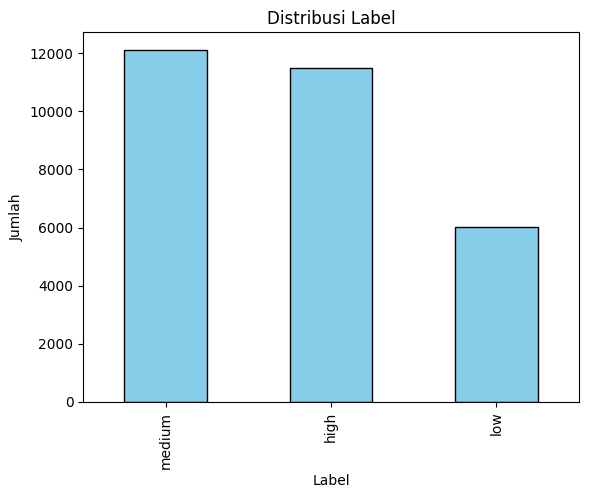

In [ ]:
import matplotlib.pyplot as plt

# Membuat bar plot untuk distribusi label
label_distribution = df['Priority'].value_counts()

# Membuat plot
label_distribution.plot(kind='bar', color='skyblue', edgecolor='black')

# Menambahkan judul dan label
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')

# Menampilkan grafik
plt.show()

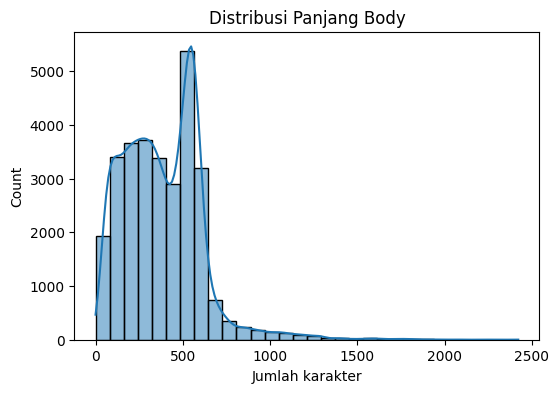

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 4. Panjang teks Ticket Description
panjang_teks = df['Body'].astype(str).apply(len)
plt.figure(figsize=(6,4))
sns.histplot(panjang_teks, bins=30, kde=True)
plt.title("Distribusi Panjang Body")
plt.xlabel("Jumlah karakter")
plt.show()

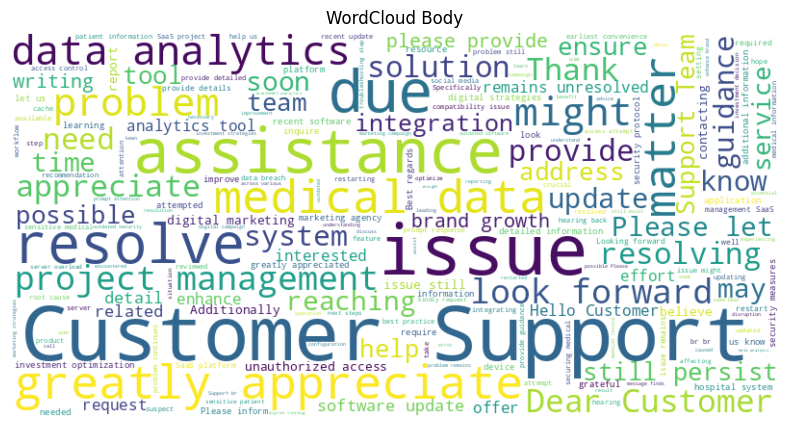

In [ ]:
from wordcloud import WordCloud

subject_text = " ".join(df['Body'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(subject_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Body")
plt.show()

# Prepeocessing

In [ ]:
df['Body'] = df['Body'].fillna("").astype(str)

In [ ]:
def lowercase(text):
    return text.lower()

df['text_clean'] = df['Body'].apply(lowercase)

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.3 MB/s eta 0:00:00


In [ ]:
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import nlpaug.augmenter.word as naw

syn_aug = naw.SynonymAug(aug_src='wordnet')
def synonym_augment(text, n=2):
    return [syn_aug.augment(text) for _ in range(n)]
minor_df = df[df['Priority'] == 'low']

aug_texts = []
for text in minor_df['text_clean']:
    aug_texts.extend(synonym_augment(text, n=2))

aug_df = pd.DataFrame({
    'text_clean': aug_texts,
    'Priority': 'low'
})

df_aug = pd.concat([df, aug_df]).reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle

X = df_aug['text_clean']
y = df_aug['Priority']

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Lihat mapping antara label asli dan numerik
label_map = {i: label for i, label in enumerate(le.classes_)}
print("Mapping Label Asli ke Angka:")
for i, label in label_map.items():
    print(f"{i} = {label}")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

Mapping Label Asli ke Angka:
0 = high
1 = low
2 = medium


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Simpan masing-masing split ke CSV
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train = X_train.apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
X_val   = X_val.apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
X_test  = X_test.apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
def tokenize_texts(texts, max_len=128):
    return tokenizer(
        texts,
        add_special_tokens=True,   # [CLS] dan [SEP]
        padding='max_length',      # supaya semua panjang sama
        truncation=True,           # jika teks lebih panjang dari max_len
        max_length=max_len,
        return_tensors='pt'        # PyTorch, kalau pake TF ganti 'tf'
    )

train_encodings = tokenize_texts(X_train.tolist())
val_encodings   = tokenize_texts(X_val.tolist())
test_encodings  = tokenize_texts(X_test.tolist())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.save_pretrained("bert")

('bert/tokenizer_config.json',
 'bert/special_tokens_map.json',
 'bert/vocab.txt',
 'bert/added_tokens.json')

In [ ]:
import torch

class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = BERTDataset(train_encodings, y_train)
val_dataset = BERTDataset(val_encodings, y_val)
test_dataset = BERTDataset(test_encodings, y_test)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Modeling

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
EPOCHS = 8

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    total_train_loss = 0
    correct_train, total_train = 0, 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # ===== VALIDATION =====
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_val_loss += outputs.loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_losses[-1]:.4f}, "
        f"Train Acc: {train_accuracies[-1]:.4f} | "
        f"Val Loss: {val_losses[-1]:.4f}, "
        f"Val Acc: {val_accuracies[-1]:.4f}"
    )

Epoch 1/8 | Train Loss: 0.7673, Train Acc: 0.6059 | Val Loss: 0.7128, Val Acc: 0.6433
Epoch 2/8 | Train Loss: 0.6563, Train Acc: 0.6817 | Val Loss: 0.6360, Val Acc: 0.6804
Epoch 3/8 | Train Loss: 0.5181, Train Acc: 0.7687 | Val Loss: 0.5537, Val Acc: 0.7566
Epoch 4/8 | Train Loss: 0.3596, Train Acc: 0.8520 | Val Loss: 0.5575, Val Acc: 0.7825
Epoch 5/8 | Train Loss: 0.2366, Train Acc: 0.9075 | Val Loss: 0.5862, Val Acc: 0.8065
Epoch 6/8 | Train Loss: 0.1626, Train Acc: 0.9378 | Val Loss: 0.6089, Val Acc: 0.8241
Epoch 7/8 | Train Loss: 0.1190, Train Acc: 0.9553 | Val Loss: 0.6934, Val Acc: 0.8191
Epoch 8/8 | Train Loss: 0.0975, Train Acc: 0.9621 | Val Loss: 0.6812, Val Acc: 0.8271


In [ ]:
model.save_pretrained("bert.zip")

In [ ]:
model.save_pretrained("bert")
tokenizer.save_pretrained("bert")

('bert/tokenizer_config.json',
 'bert/special_tokens_map.json',
 'bert/vocab.txt',
 'bert/added_tokens.json')

In [ ]:
!zip -r bert_model.zip bert

  adding: bert/ (stored 0%)
  adding: bert/special_tokens_map.json (deflated 42%)
  adding: bert/tokenizer_config.json (deflated 75%)
  adding: bert/config.json (deflated 51%)
  adding: bert/vocab.txt (deflated 53%)
  adding: bert/model.safetensors (deflated 7%)


In [ ]:
from google.colab import files
files.download("bert_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

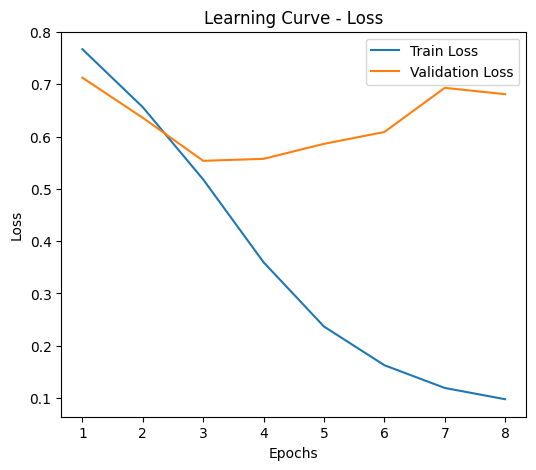

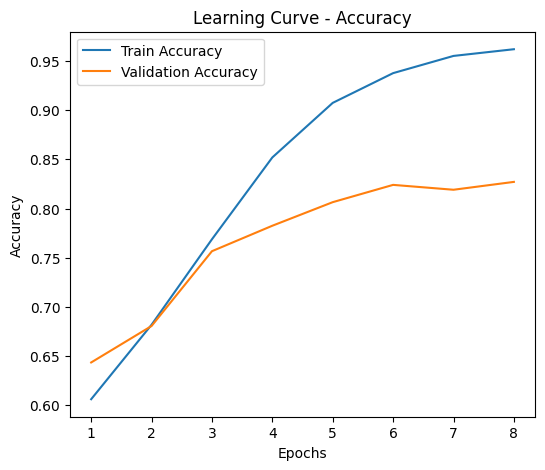

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plotting learning curve for loss
plt.figure(figsize=(6, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()

# Plotting learning curve for accuracy
plt.figure(figsize=(6, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')
plt.show()

In [ ]:
# Evaluating on Test Data
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Classification Report (FINAL RESULT)
print("=== TEST CLASSIFICATION REPORT ===")
print(classification_report(
    all_targets,
    all_predictions,
    target_names=le.classes_
))

=== TEST CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        high       0.78      0.81      0.79      1809
         low       0.95      0.86      0.90      2614
      medium       0.72      0.78      0.75      1829

    accuracy                           0.82      6252
   macro avg       0.81      0.82      0.81      6252
weighted avg       0.83      0.82      0.83      6252



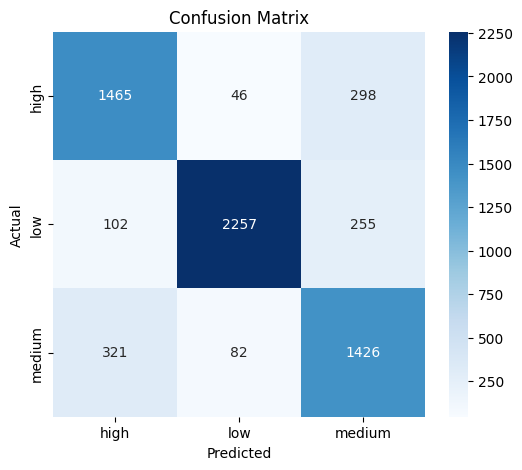

In [ ]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
df['Priority'].value_counts()

,count
Priority,
medium,12126
high,11512
low,6013
